In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm # progress bar
# for augmentation
import random
import skimage as sk
from skimage import transform

# mount google drive locally
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/AAIIS Project/data/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
image_sz = 224
def loadData(paths):
  #data arrays
  x = [] #image array
  ybrand = [] #brand label
  ytype = [] #type label
  #temp arrays
  wt_brand = []
  wt_type = []
  #weight arrays for class imbalance
  weight_b = []
  weight_t = []
  #read label csv
  label = pd.read_csv("trainLabels.csv")
  
  for img in tqdm(os.listdir(paths)):
    path = os.path.join(paths, img)
    image = cv2.imread(path)#cv2.IMREAD_GRAYSCALE
    tmp = label[label["filename"].str.contains(img)]
    x1, x2, w, h = list(tmp["bounding_box"])[0][1:-1].split(',')
    image = image[int(x2):int(h), int(x1):int(w)]
    image = cv2.resize(image,(image_sz, image_sz))
    image = image.reshape(3,image_sz,image_sz)
    x.append(image)
    ybrand.append(tmp["brand"])
    ytype.append(tmp["type"])
    
    wt_brand.append(tmp["brand"].values)
    wt_type.append(tmp["type"].values)
    
  # get weight for brand classes
  classes, counts = np.unique(wt_brand, return_counts=True)
  for i in range(len(classes)):
    weight_b.append(len(ybrand)/counts[i])
  #get weight for type classes
  classes, counts = np.unique(wt_type, return_counts=True)
  for i in range(len(classes)):
    weight_t.append(len(ytype)/counts[i])
    
  return x, ybrand, ytype, weight_b, weight_t

In [3]:
# load train data
x, y_b, y_t, weight_b, weight_t = loadData('images/')

100%|██████████| 2100/2100 [00:29<00:00, 71.41it/s]


In [0]:
#resnet 152
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.resnet = models.resnet152(pretrained=True)
    self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))
    self.convb1 = nn.Conv2d(2048, 2048, kernel_size=(1,1), stride=(1,1), padding=0)
    self.convt1 = nn.Conv2d(2048, 2048, kernel_size=(1,1), stride=(1,1), padding=0)
    self.convb2 = nn.Conv2d(2048, 1000, kernel_size=(1,1), stride=(1,1), padding=0)
    self.convt2 = nn.Conv2d(2048, 1000, kernel_size=(1,1), stride=(1,1), padding=0)
    self.convb3 = nn.Conv2d(1000, 6, kernel_size=(1,1), stride=(1,1), padding=0)
    self.convt3 = nn.Conv2d(1000, 5, kernel_size=(1,1), stride=(1,1), padding=0)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.75)
  
  def cuda(self, device=None):
    self = super().cuda(device)
    self.resnet = self.resnet.cuda(device)
    return self 
  
  def forward(self, x):
    y = self.resnet(x)
    y1 = self.convb1(y)
    y2 = self.convt1(y)
    y1 = self.dropout(y1)
    y2 = self.dropout(y2)
    y1 = self.relu(self.convb2(y1))
    y2 = self.relu(self.convt2(y2))
    y1 = self.dropout(y1)
    y2 = self.dropout(y2)
    y1 = self.convb3(y1)
    y2 = self.convt3(y2)
    return y1, y2
    
# model = ResNet()  
# model.cuda()
# y1= model(data[0]['x'].reshape(-1,3,image_sz,image_sz).type(torch.cuda.FloatTensor))
# y1.shape

In [0]:
# VGG16 model with batch normalization
# class vgg(nn.Module):
#  def __init__(self):
#    super(vgg, self).__init__()
#    self.vgg16_model = models.vgg16_bn(pretrained = True)
#    self.lin_brand = nn.Linear(1000, 6) # seperate classifier for brand
#    self.lin_type = nn.Linear(1000, 5) # seperate classifier for type
  
#  def cuda(self, device=None): # for gpu usage
#    self = super().cuda(device)
#    self.vgg16_model = self.vgg16_model.cuda(device)
#    return self

#  def forward(self, input): #perform forward operation
#    y = self.vgg16_model(input)
#    y1 = self.lin_brand(y)
#    y2 = self.lin_type(y)
#    return y1, y2
  

In [0]:
# Custom model
# class CarClassification(nn.Module):
#   def __init__(self):
#     super(CarClassification, self).__init__()
#     self.CarClassification = nn.Sequential(nn.Conv2d(3,100, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#                                   nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                                   nn.ReLU(inplace=True),
#                                   nn.Dropout(0.2),
#                                   nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#                                   nn.Conv2d(100,100, kernel_size=(3, 3), stride=(1,1), padding=(1,1)),
#                                   nn.ReLU(inplace=True),
#                                   nn.Dropout(0.2),
#                                   nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                                   nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#                                   nn.Conv2d(100,50, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
#                                   nn.BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                                   nn.ReLU(inplace=True),
#                                   nn.Dropout(0.2),
#                                   nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#                                   nn.Conv2d(50,100,kernel_size=(16,16), stride=(1,1), padding=0),
#                                   nn.ReLU(inplace=True),
#                                   nn.Dropout(0.2),
#                                   nn.Conv2d(100,100,kernel_size=(1,1), stride=(1,1), padding=0),
#                                  )
#     self.conv_brand = nn.Conv2d(100,6,kernel_size=(1,1), stride=(1,1), padding=0)
#     self.conv_type = nn.Conv2d(100,5,kernel_size=(1,1), stride=(1,1), padding=0)
#   def cuda(self, device=None):
#     self = super().cuda(device)
#     self.CarClassification = self.CarClassification.cuda(device)
#     return self 

#   def forward(self, input):
#     y = self.CarClassification(input)
#     y1 = self.conv_brand(y)
#     y2 = self.conv_type(y)
#     return y1, y2#y[0][6:11] [0][0:6]

In [0]:
class Car:
  def __init__(self, x, y_t, y_b, transform):
    self.x = x
    self.y_t = y_t
    self.y_b = y_b
    self.transform = transform
  
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    #y = []
    image = self.x[idx]
    label1 = self.y_b[idx]
    label2 = self.y_t[idx]
    label1 = int(label1.map({'audi':0, 'bmw':1, 'chevrolet':2, 'dodge':3, 'ford':4, 'hyundai':5 }))
    label2 = int(label2.map({'convertible':0, 'coupe':1, 'hatchback':2, 'sedan':3, 'suv':4 }))
    
    data = {'x':image, 'yb':label1, 'yt':label2}
    if self.transform:
        data = self.transform(data)
    return data
  
# converts to torch tensor
class ToTensor(object):
  def __call__(self, data):
    x, y1, y2 = torch.from_numpy(data['x'].copy()), data['yb'], data['yt']
    return {'x': x.type(torch.DoubleTensor),
                'yb': y1, 'yt':y2}
# Normalize data
class Normalize(object):
  def __call__(self, data):
    return {'x': data['x']/255, 'yb': data['yb'], 'yt':data['yt']}

# Data Augmentation
class Augmentation(object):
  def __call__(self, data):
    x, y1, y2 = data['x'], data['yb'], data['yt']
    i = random.randint(1,5)
    if i == 1: # returns same as input data
      return {'x':x, 'yb':y1, 'yt':y2}
    if i ==10: # Random rotation // not working
      random_degree = random.uniform(-25, 25)
      return {'x':sk.transform.rotate(x, random_degree), 'yb':y1, 'yt':y2}
    if i == 2: # random noise
      return {'x':sk.util.random_noise(x), 'yb':y1, 'yt':y2}
    if i == 3: # flip upside down
      return {'x':np.flipud(x), 'yb':y1, 'yt':y2}
    if i == 4: # flip upside down
      return {'x':np.fliplr(x), 'yb':y1, 'yt':y2}
    if i == 5: # random noise
      return {'x':sk.util.random_noise(x), 'yb':y1, 'yt':y2}


In [0]:
lr = 0.0001
carclassification = ResNet() # initialize
# convert model parameters to work with gpu
carclassification.cuda()
# cross entropy loss
loss_func1 = nn.CrossEntropyLoss(weight = torch.tensor(weight_b)).cuda() # weighted loss for brand
loss_func2 = nn.CrossEntropyLoss(weight = torch.tensor(weight_t)).cuda() # weighted loss for type
#loss_func = nn.BCELoss(weight = weight).cuda()

#optimizers

optimizer = optim.Adam(carclassification.parameters(), lr=lr)
#optimizer = optim.RMSprop(carclassification.parameters(), lr = lr)
#optimizer = optim.SGD(carclassification.parameters(), lr = lr, momentum=0.9)

In [0]:
def accuracy_rate(y, t):
  return np.mean(np.array(y) == np.array(t))

def accuracy_overall(y1, y2, t1, t2):
  return np.mean( ( (np.array(y1) == np.array(t1)) & (np.array(y2) == np.array(t2) )))

def train(trainLoader, valLoader, iter, x_, Y_t, y_b):
  for i in range(iter):
    
    train_loss = 0.0
    val_loss = 0.0
    y_1 = []
    y_2 = []
    t_1 = []
    t_2 = []
   
    print("iteration : {}".format(i))
    for j, data in enumerate(trainLoader, 0):
      x, t1, t2 = data['x'], data['yb'], data['yt']
      
      # convert tensors to work with gpu
      x = x.type(torch.cuda.FloatTensor)
      t1 = t1.type(torch.cuda.LongTensor)
      t2 = t2.type(torch.cuda.LongTensor)
      
      optimizer.zero_grad()
      y1, y2 = carclassification.forward(x)
      y1 = y1.reshape(-1,6)
      y2 = y2.reshape(-1,5)
      print(j, end =" ")
     # y = torch.softmax(y)
      loss1 = loss_func1(y1, t1)
      loss2 = loss_func2(y2, t2)
      loss = loss1 + loss2
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      
      for j in range(len(t1)):
        y_1.append(torch.argmax(torch.softmax(y1 , dim = 1), 1)[j].item())
        y_2.append(torch.argmax(torch.softmax(y2 , dim = 1), 1)[j].item())
        t_1.append(t1[j].item())
        t_2.append(t2[j].item())
      
    print("TRAIN::: brand accuracy: {} || type accuracy: {} || Overall: {}".format(accuracy_rate(y_1, t_1), accuracy_rate(y_2, t_2), accuracy_overall(t_1, t_2, y_1, y_2)))#accuracy_rate(y_1, t_1), accuracy_rate(y_2, t_2), accuracy_overall(t_1, t_2, y_1, y_2)))
    
    y_1 = []
    y_2 = []
    t_1 = []
    t_2 = []
    
    for k, data in enumerate(valLoader, 0):
      x, t1, t2 = data['x'], data['yb'], data['yt']
      # convert tensors to work with gpu
      x = x.type(torch.cuda.FloatTensor)
      t1 = t1.type(torch.cuda.LongTensor)
      t2 = t2.type(torch.cuda.LongTensor)

      y1, y2 = carclassification.forward(x)
      y1 = y1.reshape(-1,6)
      y2 = y2.reshape(-1,5)
      
      print(k, end =" ")
      
      loss1 = loss_func1(y1, t1)
      loss2 = loss_func2(y2, t2)
      loss = loss1 + loss2
      val_loss += loss.item()
      
      for j in range(len(t1)):
        y_1.append(torch.argmax(torch.softmax(y1 , dim = 1), 1)[j].item())
        y_2.append(torch.argmax(torch.softmax(y2 , dim = 1), 1)[j].item())
        t_1.append(t1[j].item())
        t_2.append(t2[j].item())
      
    print("VAL ::: brand accuracy: {} || type accuracy: {} || Overall: {}".format(accuracy_rate(y_1, t_1), accuracy_rate(y_2, t_2), accuracy_overall(t_1, t_2, y_1, y_2)))
    print("Train Loss:{} || Validation Loss:{}".format(train_loss/2100, val_loss/169))
    
    # Adaptive learning rate ---------------------------use for adaptive learning rate
    #for param_group in optimizer.param_groups:
    #  param_group['lr'] = lr/((i) + 1)
    
    # for data Augmentation in middle of iterations
    if i>=1:  ## set iteration after which data has to be augmented
      aug_data = Car(x_, y_t, y_b, transform= transforms.Compose([Normalize(),Augmentation(), ToTensor()]))
      trainLoader = DataLoader(aug_data, batch_size=30, shuffle=True, num_workers=4)

  print("done")

In [9]:
data = Car(x, y_t, y_b, transform= transforms.Compose([Normalize(), ToTensor()]))
train_dataloader = DataLoader(data, batch_size=30, shuffle=True, num_workers=4)

#load val data
x_val, y_val_b, y_val_t, dummy1, dummy2 = loadData('test/')
data_val = Car(x_val, y_val_t, y_val_b, transform= transforms.Compose([Normalize(), ToTensor()]))
val_dataloader = DataLoader(data_val, batch_size=10, shuffle=False, num_workers=4)

100%|██████████| 169/169 [00:02<00:00, 78.05it/s]


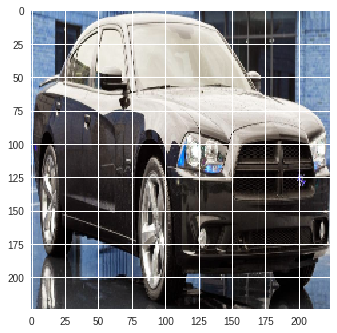

In [10]:
import matplotlib.pyplot as plt
plt.imshow(data[200]['x'].reshape([image_sz, image_sz, 3]))

In [11]:
train(train_dataloader, val_dataloader, 25, x, y_t, y_b)

iteration : 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [

KeyboardInterrupt: ignored

In [0]:
def predict(testloader):
  for k, data in enumerate(testloader, 0):
      x, t1, t2 = data['x'], data['yb'], data['yt']
      # convert tensors to work with gpu
      x = x.type(torch.cuda.FloatTensor)
      t1 = t1.type(torch.cuda.LongTensor)
      t2 = t2.type(torch.cuda.LongTensor)

      y1, y2 = carclassification.forward(x)
      y1 = y1.reshape(-1,6)
      y2 = y2.reshape(-1,5)
      
      for j in range(len(t1)):
        print("Actual brand:{} || Predicted brand: {} || Actual type:{} || Predicted type: {}".format(t1[j].item(), torch.argmax(torch.softmax(y1 , dim = 1), 1)[j].item(), t2[j].item(), torch.argmax(torch.softmax(y2 , dim = 1), 1)[j].item()))


In [13]:
#load test data
x_test, y_test_b, y_test_t, dummy1, dummy2 = loadData('test/')
data_test = Car(x_test, y_test_t, y_test_b, transform= transforms.Compose([Normalize(), ToTensor()]))
test_dataloader = DataLoader(data_test, batch_size=10, shuffle=False, num_workers=4)

100%|██████████| 169/169 [00:02<00:00, 76.16it/s]


In [16]:
predict(test_dataloader)

Actual brand:1 || Predicted brand: 5 || Actual type:3 || Predicted type: 0
Actual brand:2 || Predicted brand: 5 || Actual type:4 || Predicted type: 4
Actual brand:2 || Predicted brand: 1 || Actual type:0 || Predicted type: 4
Actual brand:5 || Predicted brand: 5 || Actual type:4 || Predicted type: 3
Actual brand:2 || Predicted brand: 0 || Actual type:4 || Predicted type: 2
Actual brand:5 || Predicted brand: 1 || Actual type:3 || Predicted type: 4
Actual brand:1 || Predicted brand: 5 || Actual type:4 || Predicted type: 4
Actual brand:2 || Predicted brand: 5 || Actual type:3 || Predicted type: 3
Actual brand:5 || Predicted brand: 0 || Actual type:4 || Predicted type: 0
Actual brand:2 || Predicted brand: 5 || Actual type:0 || Predicted type: 1
Actual brand:0 || Predicted brand: 5 || Actual type:3 || Predicted type: 4
Actual brand:5 || Predicted brand: 5 || Actual type:4 || Predicted type: 1
Actual brand:0 || Predicted brand: 2 || Actual type:3 || Predicted type: 2
Actual brand:4 || Predict